<a href="https://colab.research.google.com/github/opensim-org/opensim-models/blob/master/notebooks/tutorials/Tutorial_2_Creating_and_Simulating_a_simple_arm_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Creating a simple arm model

## 2.1. Objectives

**Purpose**

The purpose of this tutorial is to introduce you to the creation of musculoskeletical models using [OpenSim](https://opensim.stanford.edu/) [[1]](https://doi.org/10.1109/TBME.2007.901024). In this tutorial you will:

*   Learn to create a simple arm model.
*   Simulate the model using Forward Kinematics.
*   Plot information obtained from the simulation.

**Format**

In this tutorial, you will create an arm model. The model is very simple, and consists on two bones (humerus and radius), and a muscle to bend the arm (biceps).

The first step of this tutorial consisttts on seting up the environment (See ***Tutorial 1: Introduction to OpenSim in Colab***, and then you will programatically create the model by defining the necessary bodies, muscles and joints. Finally, you will perform Forward Kinematics on the model to obtain kinematic data.

## 2.2. Setup Conda and OpenSim

First, set up the environment by executing the following cell (See ***Tutorial 1: Introduction to OpenSim in Colab***).

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:29
🔁 Restarting kernel...


Now, let's install the OpenSim conda package.

In [ ]:
!conda install -c opensim-org opensim

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - opensim


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2022.6.15          |     pyhd8ed1ab_1         154 KB  conda-forge
    libblas-3.9.0              |16_linux64_openblas          13 KB  conda-forge
    libcblas-3.9.0             |16_linux64_openblas          13 KB  conda-forge
    libgfortran-ng-12.1.0      |      h69a702a_16          23 KB  conda-forge
    libgfortran5-12.1.0        |      hdcd56e2_16         1.8 MB  conda-forge
    liblapack-3.9.0            |16_linux64_openblas          13 KB  conda-forge
    libopenblas-0.3.21         |pthreads_h78a6416_2        10.1 MB  conda-forge
    numpy-1.21.6               |  

## 2.3. Create the model

Now it's time to create the model. First, you are going to import opensim and create an empty model named "bicep_curl".

In [ ]:
import opensim as osim

# Create empty model and assign the name "bicep_curl" to it.
arm = osim.Model()
arm.setName("bicep_curl")

Now let's create two bodies (the bones), each with a mass of 1kg. The center of mass is at the body¡s origin in both bones (`osim.Vec3(0)`), and the moments and products of inertia correspond to ellipsoids with radios of 0.1, 0.5 and 0.1, in the x, y and z directions, respectively.

In [ ]:
# Define humerus.
humerus = osim.Body("humerus",
                    1.0,
                    osim.Vec3(0),
                    osim.Inertia(0.1, 0.5, 0.1))

# Define radius.
radius = osim.Body("radius",
                   1.0,
                   osim.Vec3(0),
                   osim.Inertia(0.1, 0.5, 0.1))

The model needs pin joints. The first pin joint corresponds with the shoulder, and connects the upper extreme of the humerus with the ground (the humerus is the root of the model). The second pin joint corresponds with the elbow and connects the lower extreme of the humerus with the upper extreme of the radius. Assume each body is 1m long.

In [ ]:
# Shoulder pin joint from the ground to the humerus, so it is fixed and don't fall.
shoulder = osim.PinJoint("shoulder",
                         arm.getGround(), # PhysicalFrame
                         osim.Vec3(0),
                         osim.Vec3(0),
                         humerus, # PhysicalFrame
                         osim.Vec3(0, 0.5, 0),
                         osim.Vec3(0))

# Elbow pin joint from the humerus to the radius.
elbow = osim.PinJoint("elbow",
                      humerus, # PhysicalFrame
                      osim.Vec3(0, -0.5, 0),
                      osim.Vec3(0),
                      radius, # PhysicalFrame
                      osim.Vec3(0, 0.5, 0),
                      osim.Vec3(0))

In order to flex the elbow, now you will add a muscle (actuator for robotics people) representing the biceps to the model. The muscle is created as a configurable equilibrium muscle [[2]](https://doi.org/10.1115/1.4023390), and has a maximum isometric force of 100, optimal fibre length of 0.6, tendom slack length of 0.55, and null pennation angle. Then, two path points are defined as the origin point of the muscle in the humerus, and the insertion point of the muscle in the radius.


In [ ]:
# Define the bideps as an equilibrium muscle.
biceps = osim.Millard2012EquilibriumMuscle("biceps",  # Muscle name
                                           100.0,  # Max isometric force
                                           0.6,  # Optimal fibre length
                                           0.55,  # Tendon slack length
                                           0.0)  # Pennation angle

# Add path points to the humerus and radius, to perform forces to them.
biceps.addNewPathPoint("origin",
                       humerus,
                       osim.Vec3(0, 0.3, 0))
biceps.addNewPathPoint("insertion",
                       radius,
                       osim.Vec3(0, 0.2, 0))

In order to excitate the muscle (activate the actuator), the model needs a controler. In the following cell you will created a prescribed controler, add the biceps as actuator to the controller, and specify the excitation of the muscle.

In [ ]:
# Create a controller, add the actuator (muscle) to it, and specify excitation.
brain = osim.PrescribedController()
brain.addActuator(biceps)
brain.prescribeControlForActuator("biceps", osim.StepFunction(0.5, 3.0, 0.3, 1.0))

Now that every component of the model has been defined, let's add all of the elements to the arm model. Remember that the elements that you have defined are the bodies (bones) of the model, the joints of the model, an actuator (muscle) that performs a force over the model, and a controller (brain) that specifies how the actuator works.

In [ ]:
# Add all of the elements defined in previous cells to the model.
arm.addBody(humerus)
arm.addBody(radius)
arm.addJoint(shoulder)
arm.addJoint(elbow)
arm.addForce(biceps)
arm.addController(brain)

Now that you have build the model, you have to initialize the system. Since the shoulder is the anchored joint, it needs to be locked. The elbow needs to have an initial angle, wich we set to 0.5π rad (90º). Finally, we update the state of the muscle so it is in equilibrium.

In [ ]:
# Initialize model.
state = arm.initSystem()

# Fix the shoulder at its default angle and begin with the elbow flexed 90º degrees.
shoulder.getCoordinate().setLocked(state, True)
elbow.getCoordinate().setValue(state, 0.5 * osim.SimTK_PI)
arm.equilibrateMuscles(state)

Now, you can simulate the model. First, let's create a manager for the simulation and set the starting time to the state. Then, let's perform a Forward Kinetics simulation [[3]](https://mitpress.mit.edu/9780262044202/biomechanics-of-movement/) (Integrate the equations of motion for the specified model, given the current state with a starting time and a final time). This will return a new state with the results of the simulation.

In [ ]:
# Simulation parameters (Feel free to change this)
starting_time =  0.0
ending_time = 10.0

# Initialize the system and set initial time.
state.setTime(starting_time)

# Get and initialize manager with the state.
manager = osim.Manager(arm)
manager.initialize(state)

# Integrate the model until the ending time.
state = manager.integrate(ending_time)

Now that the simulation has been done, you can extract the table of states. Let's also print the column labels so we have the paths of the values we can plot.

In [ ]:
# Extract table of states.
statesTable = manager.getStatesTable()

# Print labels of columns in the table.
print(statesTable.getColumnLabels())

('/jointset/shoulder/shoulder_coord_0/value', '/jointset/shoulder/shoulder_coord_0/speed', '/jointset/elbow/elbow_coord_0/value', '/jointset/elbow/elbow_coord_0/speed', '/forceset/biceps/activation', '/forceset/biceps/fiber_length')


We want to plot the shoulder and elbow positions and speed, as well of the biceps activation and fiber length over time. Lets extract the desired data from the table of state.

In [ ]:
# Extract time values for the x axis.
times = statesTable.getIndependentColumn()

# Extract shoulder data.
shoulder_pos = statesTable.getDependentColumn('/jointset/shoulder/shoulder_coord_0/value')
shoulder_speed = statesTable.getDependentColumn('/jointset/shoulder/shoulder_coord_0/speed')

# Extract elbow data.
elbow_pos = statesTable.getDependentColumn('/jointset/elbow/elbow_coord_0/value')
elbow_speed = statesTable.getDependentColumn('/jointset/elbow/elbow_coord_0/speed')

# Extract biceps data.
biceps_activation = statesTable.getDependentColumn('/forceset/biceps/activation')
biceps_fiber_length = statesTable.getDependentColumn('/forceset/biceps/fiber_length')

## 2.4. Plotting data

In this section you are going to plot the results of the simulation using two well known python libraries: Matplotlib abd Seaborn.

### 2.4.1. Matplotlib

The following cell plots the desired columns (shoulder_pos, shoulder_speed, elbow_pos, elbow_speed, biceps_act and biceps_fib_len) using matplotlib. Each column is plotted in a different subplot.

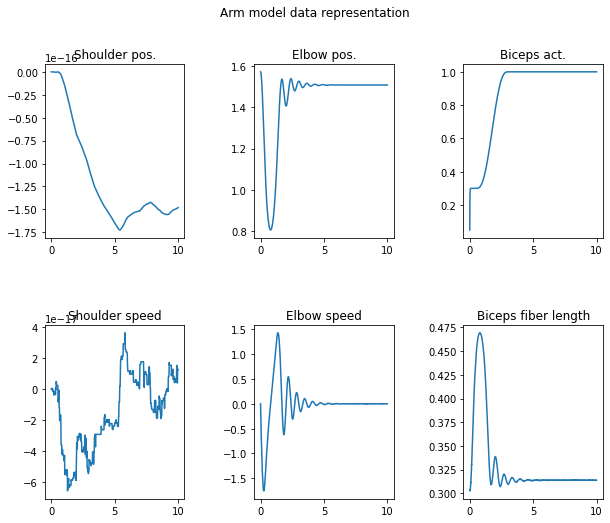

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots.
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Arm model data representation')

# Shoulder pos and speed to column 1.
axs[0, 0].plot(times, shoulder_pos.to_numpy())
axs[0, 0].set_title('Shoulder pos.')
axs[1, 0].plot(times, shoulder_speed.to_numpy())
axs[1, 0].set_title('Shoulder speed')

# Elbow pos and speed to column 2.
axs[0, 1].plot(times, elbow_pos.to_numpy())
axs[0, 1].set_title('Elbow pos.')
axs[1, 1].plot(times, elbow_speed.to_numpy())
axs[1, 1].set_title('Elbow speed')

# Biceps act and length to column 3.
axs[0, 2].plot(times, biceps_activation.to_numpy())
axs[0, 2].set_title('Biceps act.')
axs[1, 2].plot(times, biceps_fiber_length.to_numpy())
axs[1, 2].set_title('Biceps fiber length')

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

### 2.4.2. Seaborn

The following cell plots the desired columns (shoulder_pos, shoulder_speed, elbow_pos, elbow_speed, biceps_act and biceps_fib_len) using seaborn. Each column is plotted in a different subplot.

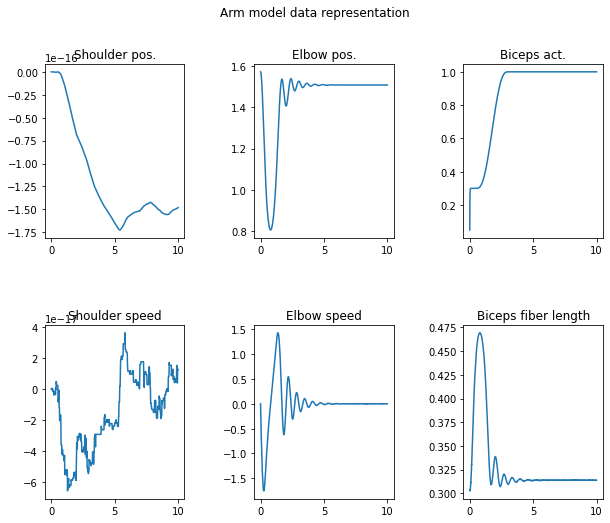

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(10, 8))

fig.suptitle('Arm model data representation')

# Shoulder pos and speed to column 1.
sns.lineplot(x=times, y=shoulder_pos.to_numpy(), ax=axes[0, 0]).set(title='Shoulder pos.')
sns.lineplot(x=times, y=shoulder_speed.to_numpy(), ax=axes[1, 0]).set(title='Shoulder speed')

# Elbow pos and speed to column 2.
sns.lineplot(x=times, y=elbow_pos.to_numpy(), ax=axes[0, 1]).set(title='Elbow pos.')
sns.lineplot(x=times, y=elbow_speed.to_numpy(), ax=axes[1, 1]).set(title='Elbow speed')

# Biceps act and length to column 3.
sns.lineplot(x=times, y=biceps_activation.to_numpy(), ax=axes[0, 2]).set(title='Biceps act.')
sns.lineplot(x=times, y=biceps_fiber_length.to_numpy(), ax=axes[1, 2]).set(title='Biceps fiber length')

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

## 2.5. Conclussion

In this tutorial you have created a simple arm model defined by two bones (bodies), two joints and a muscle (actuator). Then, you have simulated the model and represented the calculated values.

To create more complex models graphically and visualize them, check [OpenSim Creator](https://opensimcreator.com/). OpenSim Creator is open-source software that enables people to visually build, edit, and simulate OpenSim models. Available for free on Windows, Mac, and Linux.

## 2.6. Useful Links





> **OpenSim Website:** https://opensim.stanford.edu/
>
> **OpenSim API Documentation:** https://simtk.org/api_docs/opensim/api_docs/
> 
> **OpenSim Creator Website:** https://opensimcreator.com/
> 
> **SimTK Website:** https://simtk.org/projects/opensim
> 
> **Biomecanics of Movement's Course:** https://www.youtube.com/channel/UCDNGy0KKNLQ-ztcL5h2Z6zA

## 2.7. References




> [1].   Delp, S. L., Anderson, F. C., Arnold, A. S., Loan, P., Habib, A., John, C. T., Guendelman, E., & Thelen, D. G. (2007). **OpenSim: open-source software to create and analyze dynamic simulations of movement.** *IEEE Transactions on Bio-Medical Engineering*, 54(11), 1940–1950. https://doi.org/10.1109/TBME.2007.901024
>
> [2] Millard, M., Uchida, T., Seth, A., & Delp, S. L. (2013). **Flexing computational muscle: Modeling and simulation of musculotendon dynamics.** *Journal of Biomechanical Engineering*, 135(2). https://doi.org/10.1115/1.4023390
>
> [3].   Uchida, T. K., Delp, S. L., & Delp, D. (2021). **Biomechanics of movement: The science of sports, robotics, and rehabilitation.** *MIT Press*. https://mitpress.mit.edu/9780262044202/biomechanics-of-movement/